In [7]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, UpsamplingCARE

In [8]:
(X,Y), (X_val,Y_val), axes = load_training_data('/data/u934/service_imagerie/v_kapoor/PairTrainingData/upsampling3D.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 14285
number of validation images:	 1587
image size (3D):		 (8, 64, 64)
axes:				 SZYXC
channels in / out:		 1 / 1


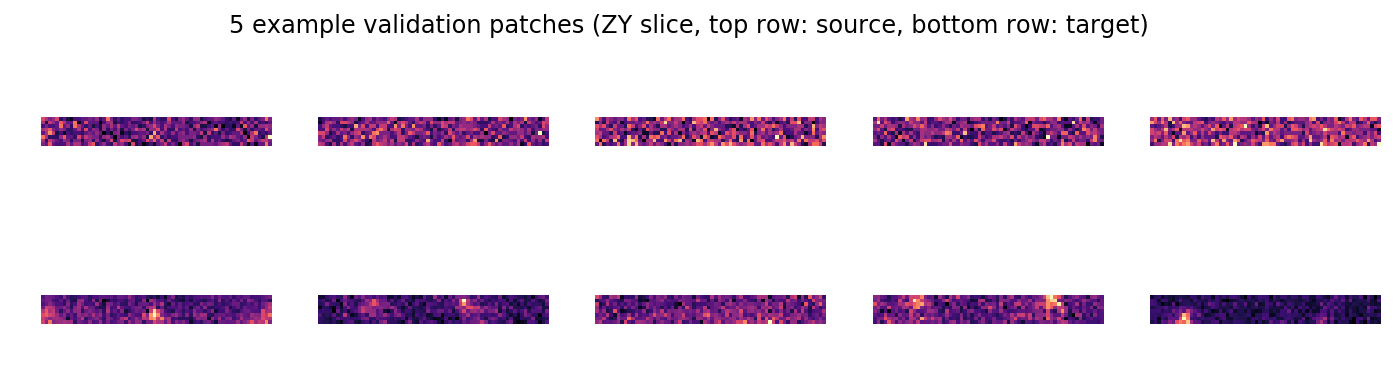

In [9]:
plt.figure(figsize=(12,3))
plot_some(X_val[:5,...,0,0],Y_val[:5,...,0,0])
plt.suptitle('5 example validation patches (ZY slice, top row: source, bottom row: target)');

In [10]:
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=400, train_batch_size=16)
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'patience': 10, 'factor': 0.5}, train_steps_per_epoch=400, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 3,
 'probabilistic': False,
 'train_batch_size': 16,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 100,
 'train_learning_rate': 0.0004,
 'train_loss': 'mae',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 400,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': True}

In [11]:
model = UpsamplingCARE(config, 'upSampling3DSyntheticLow', basedir='models')

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/models/care_standard.py:99: UserWarning: output path for model already exists, files may be overwritten: /data/u934/service_imagerie/v_kapoor/anaconda2/bin/CSBDeep/examples/CAREforCurie/upsampling3D/models/upSampling3DSyntheticLow
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [ ]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
400/400 [==============================] - 348s 871ms/step - loss: 0.1097 - mse: 0.0233 - mae: 0.1097 - val_loss: 0.0998 - val_mse: 0.0186 - val_mae: 0.0998
Epoch 2/100
400/400 [==============================] - 354s 886ms/step - loss: 0.0973 - mse: 0.0179 - mae: 0.0973 - val_loss: 0.0978 - val_mse: 0.0180 - val_mae: 0.0978
Epoch 3/100
400/400 [==============================] - 352s 881ms/step - loss: 0.0938 - mse: 0.0159 - mae: 0.0938 - val_loss: 0.0907 - val_mse: 0.0146 - val_mae: 0.0907
Epoch 4/100
400/400 [==============================] - 352s 880ms/step - loss: 0.0903 - mse: 0.0144 - mae: 0.0903 - val_loss: 0.0886 - val_mse: 0.0138 - val_mae: 0.0886
Epoch 5/100
400/400 [==============================] - 352s 881ms/step - loss: 0.0877 - mse: 0.0134 - mae: 0.0877 - val_loss: 0.0887 - val_mse: 0.0142 - val_mae: 0.0887
Epoch 6/100
400/400 [==============================] - 352s 880ms/step - loss: 0.0864 - mse: 0.0130 - mae: 0.0864 - val_loss: 0.0855 - val_mse: 0.0127 - va

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

In [ ]:
plt.figure(figsize=(12,4.5))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5,...,0,0],Y_val[:5,...,0,0],_P[...,0,0],pmax=99.5)
plt.suptitle('5 example validation patches (ZY slice)\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [ ]:
model.export_TF()